<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>

# ***A influência das opções no preço do tivo subjacente.***
---

In [1]:
#@title Identificação do Grupo

#@markdown Integrantes do Grupo (*informe \<TIA\>,\<nome\>*)
Aluno1 = '10423914, Humberto Guttau Bravo' #@param {type:"string"}
Aluno2 = '10433651, Ricardo Zulian de Souza Amaral' #@param {type:"string"}
Aluno3 = 'None' #@param {type:"string"}
Aluno4 = 'None' #@param {type:"string"}
Aluno5 = 'None' #@param {type:"string"}



# **Apresentação**

# Problema

O mercado dereivativos tem tido aumento constante de volume, muitas vezes induzindo fortes movimentações nos mercados dos seus ativos subjacentes, as ações.  
  
Nos extremos opostos do 'zero-sum game' que é o mercado de capitais estão os investidores de varejo e os formadores de meracdo. Estudando fatores como a proporção entre tomadores e lançadores e lançapores cobertos/travados/descobertos é possível ententender se as posições abertas de derivativos são equilibradas ou polarizadas.  
  
Quando são muito polarizadas os formadores de mercado tendem a interferir no preço dos ativos subjacentes com o intuito de evitar (ou forçar) o exrcício das opções.

Buascamos aqui encontrar algoritmos de classificação que consigam identificar padrões nos contratos de opções que incitem a interferência do formador de mercado em um dia a partir das posições de derivativos consolidadas na véspera.  

O conhecimento antecipado desse pontos de interferência pode ser empregado como ferramenta para day-trade no ativo subjacente.  

# **Implementação**

# Base de Dados

A base de dados tem origem nos data-dumps diários da B3. Existe um sistema próprio de um membro do grupo que faz o download diário dos arquivos texto gerados pela bolsa e os carrega como baixados em uma base de dados ms-sql.

A característica formal da base já garante consistência, como pode ser visto na ausência de nulos na base bruta. Nulos em campo específicos como volatilidade implicita são fruto de ausência de negócio no dia e não serão utilizados no estudo.




In [2]:
# bibliotecas, globais e funções
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  # To parse the report string



rnd_seed = 42

def print_df(df_in):
    display(HTML(df_in.to_html()))



In [3]:


# Carregando base de preços de fechamento de PETR4
df_p4 = pd.read_csv('petr4.csv.gz', compression='gzip')
df_p4_opc = pd.read_csv('petr4_opc.csv.gz', compression='gzip')
print("Base do Ativo:")
print(df_p4.info())
print(df_p4.sample(5))
print("\nBase do Derivativo:")
print(df_p4_opc.info())
print_df(df_p4_opc.sample(5))

print('\nBase do ativo entre: ', df_p4['tradedate'].min(), ' e ', df_p4['tradedate'].max())
print('\nBase do derivativo entre: ', df_p4_opc['tradedate'].min(), ' e ', df_p4_opc['tradedate'].max())

Base do Ativo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tradedate   643 non-null    object 
 1   ticker      643 non-null    object 
 2   price_last  643 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.2+ KB
None
      tradedate        ticker  price_last
105  2023-06-05  PETR4              27.47
167  2023-08-31  PETR4              31.94
600  2025-06-02  PETR4              31.08
440  2024-10-04  PETR4              37.84
259  2024-01-18  PETR4              37.73

Base do Derivativo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604847 entries, 0 to 604846
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   asset_id        604847 non-null  int64  
 1   tradedate       604847 non-null  object 
 2   ticker          604847 non-null  object 
 3  

,asset_id,tradedate,ticker,asset_ticker,segment,strike,style,pos_covered,pos_blocked,pos_uncovered,oi,lenders,borrowers,iq,timo_to_expiry,moneyness,vol_implied
216950,9552,2023-10-20,PETRX306,PETR4,EQUITY PUT,25.04,E,0,17300,144700,162000,25,8,3.125000,0.150794,-0.338441,NaN
521919,12884,2024-09-18,PETRX411,PETR4,EQUITY PUT,36.44,E,0,127500,9800,137300,8,14,0.571429,0.257937,0.008022,0.253731
185256,7400,2023-09-13,PETRL366,PETR4,EQUITY CALL,35.54,E,56000,0,0,56000,1,2,0.500000,0.253968,0.075992,NaN
270518,10828,2024-01-03,PETRN200,PETR4,EQUITY PUT,18.76,E,0,6200,63700,69900,8,3,2.666667,0.119048,-0.518480,NaN
172308,7341,2023-08-28,PETRJ246,PETR4,EQUITY CALL,19.08,E,82300,6300,37100,125700,6,15,0.400000,0.146825,-0.409836,0.000000



Base do ativo entre:  2023-01-02  e  2025-07-31

Base do derivativo entre:  2023-01-02  e  2024-12-30


**Sepração de PUTs/CALLS**  

Existem dois tipos de opções: opções de compra 'CALL' e opções de venda 'PUT'. os comportamentos de preço são invertidos e é necessário separa-las para processamento. Trbalharemos aqui apenas com opções de compra. A coluna com esta definição será eliminada.

In [4]:
print(len(df_p4_opc), 'registros totais.')
df_p4_opc = df_p4_opc[df_p4_opc['segment'] == 'EQUITY CALL']
df_p4_opc = df_p4_opc.drop(columns=['segment'])
print(len(df_p4_opc), 'registros de calls após a limpeza.')
print_df(df_p4_opc.sample(5))

604847 registros totais.
314083 registros de calls após a limpeza.


,asset_id,tradedate,ticker,asset_ticker,strike,style,pos_covered,pos_blocked,pos_uncovered,oi,lenders,borrowers,iq,timo_to_expiry,moneyness,vol_implied
588926,14225,2024-12-10,PETRA306,PETR4,29.69,A,2000,34500,24800,61300,5,11,0.454545,0.103175,-0.261259,NaN
402324,12368,2024-05-20,PETRG322,PETR4,19.12,E,36200,0,27000,63200,4,13,0.307692,0.170635,-0.479728,0.000000
458453,12602,2024-07-15,PETRH384,PETR4,34.75,A,1300,153400,77500,232200,14,48,0.291667,0.095238,-0.097403,0.273017
533268,13916,2024-10-02,PETRJ453,PETR4,45.43,A,0,431000,671800,1102800,45,13,3.461538,0.047619,0.212113,0.364161
249776,10720,2023-12-05,PETRD344,PETR4,33.51,A,0,100,100,200,2,2,1.000000,0.369048,-0.035683,NaN


O rótulo de classificação será definido como se cada contrato se comportou como uma 'barreira' no pregão seguinte: o preço do ativo não conseguiu romper o strike da opção. Para isso precisamos deslocar os preços de fechamento do ativo para incorporação na base de derivativos.

In [5]:
#Criando a coluna 'next_price_last' contendo o fechamento do dia seguinte do ativo.

df_p4['next_price_last'] = df_p4['price_last'].shift(-1).fillna(0)
print_df(df_p4.head())

,tradedate,ticker,price_last,next_price_last
0,2023-01-02,PETR4,22.92,22.34
1,2023-01-03,PETR4,22.34,23.05
2,2023-01-04,PETR4,23.05,23.88
3,2023-01-05,PETR4,23.88,23.74
4,2023-01-06,PETR4,23.74,23.87


In [6]:
#incorporando a coluna next_price_last no dataframe de opções
df_p4_opc = pd.merge(df_p4_opc, df_p4[['tradedate', 'next_price_last']], on='tradedate', how='left')
print_df(df_p4_opc.head())

,asset_id,tradedate,ticker,asset_ticker,strike,style,pos_covered,pos_blocked,pos_uncovered,oi,lenders,borrowers,iq,timo_to_expiry,moneyness,vol_implied,next_price_last
0,1231,2023-01-02,PETRA1,PETR4,12.51,A,29700,10000,127100,166800,15,28,0.535714,0.055556,-0.454188,1.531464,22.34
1,1231,2023-01-02,PETRA108,PETR4,13.76,E,1900,26900,11200,40000,4,11,0.363636,0.055556,-0.399651,NaN,22.34
2,1231,2023-01-02,PETRA130,PETR4,13.01,A,3600,18100,13600,35300,3,7,0.428571,0.055556,-0.432373,NaN,22.34
3,1231,2023-01-02,PETRA132,PETR4,13.26,E,34400,26300,135100,195800,6,26,0.230769,0.055556,-0.421466,1.622768,22.34
4,1231,2023-01-02,PETRA140,PETR4,1.39,A,0,60003,1251,61254,14,5,2.800000,0.055556,-0.939354,NaN,22.34


# Revisão dos campos para preparação dos dados  
**asset_id** índice do ativo relacionado em outra tabela *remover*  
**tradedate** data de negociação, não vai ser utlizado no modelo mas é interessante para visiualização *manter*     
**ticker** código de negociação do contrato não vai ser utlizado no modelo mas é interessante para visiualização *manter*      
**asset_ticker**  código do ativo subjacente, igual em todas *remover*  
**strike** preço do ativo para exercício da opção, utilizado na rotulagem *manter*  
**style** tipo de opção, americana ou européia, tem influência em negociação *manter*  
**pos_covered** tamanho da posição vendida (número de contratos abertos) coberta *manter*  
**pos_blocked** tamanho da posição vendida (número de contratos abertos) travada *manter*  
**pos_uncovered** tamanho da posição vendida (número de contratos abertos) descoberta *manter*  
**oi** tamanho da posição (número de contratos abertos) *manter*  
**lenders** titulares de opção *manter*   
**borrowers** lançadores de opção *manter*  
**iq** titulares/lançadores *manter* https://www.clubedopairico.com.br/distorcoes-no-indice-de-qualidade-das-opcoes-o-que-isso-significa/39249  
**timo_to_expiry** prazo até o exercíco (em anos base 360dd) *manter*  
**moneyness** dentro do dinheiro / no dinheiro / fora do dinheiro. Distância relativa entre o preço do ativo e o strike da opção *manter*  
**vol_implied** volatilidade implicita calculada no dia *remover*   
**next_price_last** preço de fechamento do ativo subjecente no pregão de negociação seguinte *manter*  

In [7]:
df_p4_opc = df_p4_opc.drop(columns=['asset_id', 'asset_ticker', 'vol_implied'])


In [8]:
print_df(df_p4_opc.head())

,tradedate,ticker,strike,style,pos_covered,pos_blocked,pos_uncovered,oi,lenders,borrowers,iq,timo_to_expiry,moneyness,next_price_last
0,2023-01-02,PETRA1,12.51,A,29700,10000,127100,166800,15,28,0.535714,0.055556,-0.454188,22.34
1,2023-01-02,PETRA108,13.76,E,1900,26900,11200,40000,4,11,0.363636,0.055556,-0.399651,22.34
2,2023-01-02,PETRA130,13.01,A,3600,18100,13600,35300,3,7,0.428571,0.055556,-0.432373,22.34
3,2023-01-02,PETRA132,13.26,E,34400,26300,135100,195800,6,26,0.230769,0.055556,-0.421466,22.34
4,2023-01-02,PETRA140,1.39,A,0,60003,1251,61254,14,5,2.800000,0.055556,-0.939354,22.34


## **Modelo 1**

*Descreva resumidamente o modelo empregado.*


### **Modelo 1:** Preparação dos Dados
Preparação básica com conversão de valores alfanuméricos, remoção de multicolinearidade e criação do rótulo

In [9]:
# o campo 'style' será converito para um binário 'american' com valor 1 para americans e 0 para européias
df_opc_modelo1 = df_p4_opc.copy()
df_opc_modelo1['american'] = np.where(df_opc_modelo1['style'] == 'A', 1, 0)
df_opc_modelo1 = df_opc_modelo1.drop(columns=['style']) # removendo coluna 'style'

# criação do rótulo 'barrrier' baseado no comportamento do preço do ativo subjacente no dia seguinte
df_opc_modelo1['barrier'] = np.where(df_opc_modelo1['next_price_last'] <= df_opc_modelo1['strike'] , 1, 0)
df_opc_modelo1 = df_opc_modelo1.drop(columns=['next_price_last']) # removendo coluna 'next_price_last', não será utilizada novamente
#strike foi mantido pois pode ser útil para visualização


# oi = pos_covered pos_blocked pos_uncovered. Manter oi como número de contratos, converter pos_covered e pos_uncovered para rsão sobre oi 
# e eliminar pos_blocked que pode ser dericado das outras três variáveis
df_opc_modelo1['covered_ratio'] = df_opc_modelo1['pos_covered']/ df_opc_modelo1['oi']
df_opc_modelo1['uncovered_ratio'] = df_opc_modelo1['pos_uncovered']/ df_opc_modelo1['oi']
df_opc_modelo1 = df_opc_modelo1.drop(columns=['pos_covered', 'pos_blocked',  'pos_uncovered']) # descartando colunas processadas

#iq = lenders/borrowers. Manter iq e lenders, descartar borrowers. A razão é importante e o número total de titulares também,
#indica quão popular é uma posição. O número de lançadores vai ser removido pois pode ser derivado dos outros dois.
df_opc_modelo1 = df_opc_modelo1.drop(columns=['borrowers'])


print_df(df_opc_modelo1.sample(5))

,tradedate,ticker,strike,oi,lenders,iq,timo_to_expiry,moneyness,american,barrier,covered_ratio,uncovered_ratio
178506,2024-03-20,PETRI445,43.22,1987200,10,0.666667,1.503968,0.177657,0,1,0.000554,0.997685
188115,2024-04-10,PETRF387,38.83,145300,8,0.333333,0.198413,-0.019197,0,0,0.917412,0.075705
26417,2023-03-13,PETRC395,39.51,22000,3,1.000000,0.015873,0.633320,1,1,0.000000,1.000000
169691,2024-03-05,PETRF354,34.33,100,1,1.000000,0.297619,-0.140891,0,0,0.000000,1.000000
181186,2024-03-27,PETRE347,34.75,51100,11,1.000000,0.138889,-0.049248,1,0,0.000000,0.499022


In [10]:
#divisão da base em train & test
train_m1, test_m1 = train_test_split(df_opc_modelo1,test_size=0.3,random_state = rnd_seed)
print('Treinamento com ', len(train_m1), ' registros') 
print('Teste com ', len(test_m1), ' registros') 
X_train_m1 = train_m1.drop(columns=['barrier','tradedate','ticker','strike']) 
y_train_m1 = train_m1['barrier']
X_test_m1 = test_m1.drop(columns=['barrier','tradedate','ticker','strike']) 
y_test_m1 = test_m1['barrier']
print_df(X_train_m1.head())

Treinamento com  219858  registros
Teste com  94225  registros


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio
229283,15600,2,0.250000,0.238095,-0.588173,0,0.173077,0.826923
104940,13800,5,1.250000,0.194444,0.181484,0,0.072464,0.927536
87345,349800,14,7.000000,0.642857,0.632184,1,0.000000,0.000000
199364,56400,8,0.421053,0.214286,-0.006769,0,0.010638,0.226950
160290,54000,1,0.333333,0.063492,0.063830,1,0.000000,0.000000


### **Modelo 1:** Modelo


In [11]:
# seu código
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000,random_state=rnd_seed)
clf.fit(X_train_m1, y_train_m1)

y_pred_m1 = clf.predict(X_test_m1)

print(y_pred_m1[0:10])

my_vector = np.array(y_pred_m1)  # Example NumPy array
count_ones = np.sum(my_vector == 1)  # Or np.count_nonzero(my_vector == 1)
print(count_ones)  # Output: 3



[0 0 1 0 1 0 0 1 0 1]
34539


### **Modelo 1:** Resultados


In [27]:

cm_m1 = confusion_matrix(y_test_m1, y_pred_m1)
#print('\n---- Matriz de Confusão ---- \n')
#print(cm_m1)

accuracy_m1 = accuracy_score(y_test_m1, y_pred_m1)
print('\n---- Score de Acurácia ---- \n')
print(accuracy_m1)

report_dict_m1 = classification_report(y_test_m1, y_pred_m1,output_dict=False)
#print('\n---- Classification Report ---- \n')
#print(report_dict_m1)



report_df = pd.read_fwf(StringIO(report_dict_m1), index_col=0)  # Set first column as index

# Fill NaN with empty string to remove 'nan' displays
report_df = report_df.fillna('')

# Optional: Style it (in Jupyter, this will render with colors/alignment)
styled_df = report_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).set_caption("Classification Report")

# Display (in Jupyter) or print
display(styled_df)  # Or styled_df.to_html() for HTML output



---- Score de Acurácia ---- 

0.9703687980896789


,precision,recall,f1-score,support
0,0.980000,0.970000,0.980000,60176
1,0.950000,0.970000,0.960000,34049
accuracy,,,0.970000,94225
macro avg,0.970000,0.970000,0.970000,94225
weighted avg,0.970000,0.970000,0.970000,94225


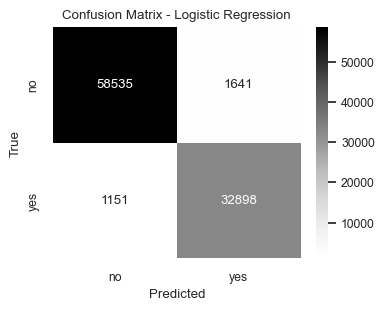

In [28]:
# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_m1, annot=True, fmt='d', cmap='Grays', 
            xticklabels=['no', 'yes'], 
            yticklabels=['no', 'yes'])
sns.set(font_scale=0.8)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### Vamos avaliar esse model inicial:


O modelo acima é uma regressão logistica, vamos primeiramente avaliar esse modelo com as seguintes estatististicas iniciais:

1. Accuracy.

3. Matriz de Confusão.

4. Classification Report

###### Analisando os resultados:

Vamos começar pela matriz de confusão, temos:

1. True Positivo: 32.898  
2. False Positivo: 1.151
3. False Negativo: 1.641
4. True Negativo: 58.535

que é um resultado posito, com menos de 3500 erros em um dataset com 94.225 observações, que é mostrado pela acurácia, que arredondando temos: 96,3% que é inicialmente satisfatório.

Agora vamos analisar nosso Classification report: 

Precision está equilibrado, já o recall mostra uma pequena discrepância nos resultados negativos que positivos.


Inicialmente o resultado é satisfatório.


In [13]:
#Visualizando a informação
print_df(X_test_m1.head())
print(y_test_m1[:5])
print(y_pred_m1[:5])

df_m1_plot = X_test_m1.copy()
df_m1_plot['barrier'] = y_pred_m1
df_m1_plot['barrier_true'] = y_test_m1
print_df(df_m1_plot.head())

df_m1_plot = df_m1_plot.join(df_p4_opc['tradedate'], how='left')
df_m1_plot = df_m1_plot.join(df_p4_opc['next_price_last'], how='left')
df_m1_plot = df_m1_plot.join(df_p4_opc['strike'], how='left')
df_m1_plot['tradedate'] = pd.to_datetime(df_m1_plot['tradedate'], format='%Y-%m-%d')

print_df(df_m1_plot.head())

,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833


29503     0
28214     0
296092    1
269205    0
38687     1
Name: barrier, dtype: int32
[0 0 1 0 1]


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio,barrier,barrier_true
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143,0,0
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155,0,0
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017,1,1
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280,0,0
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833,1,1


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio,barrier,barrier_true,tradedate,next_price_last,strike
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143,0,0,2023-03-20,23.40,12.50
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155,0,0,2023-03-16,23.51,19.01
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017,1,1,2024-11-18,37.80,41.94
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280,0,0,2024-09-19,36.26,20.69
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833,1,1,2023-04-14,26.71,48.32


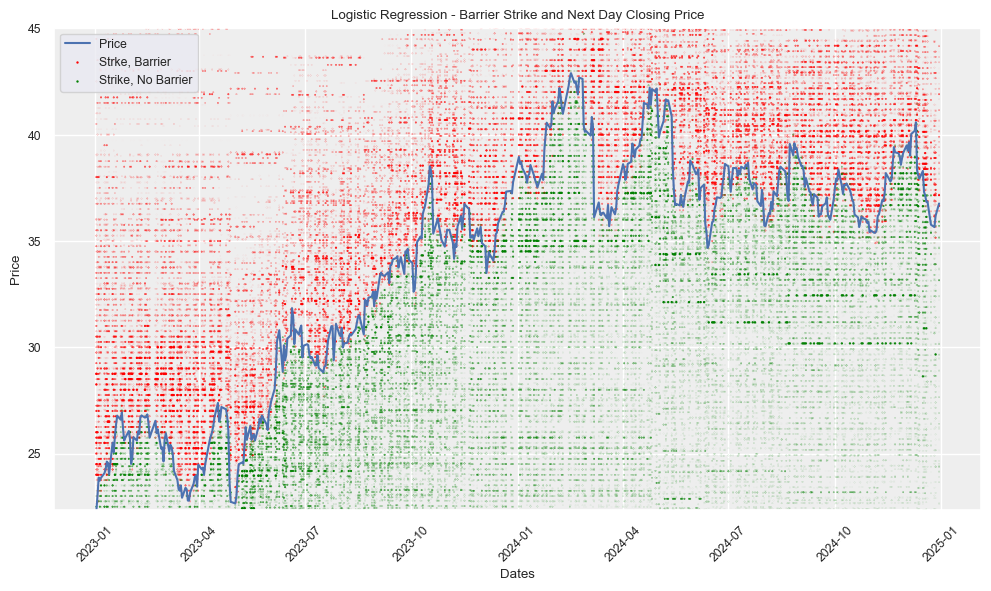

In [14]:
# Criando Gráfico
m1_line = df_m1_plot.drop_duplicates(subset='tradedate', keep='first')
m1_line = m1_line.sort_values(by='tradedate')
m1_line = m1_line[['tradedate', 'next_price_last']].copy()

plt.figure(figsize=(10, 6))



plt.plot(m1_line['tradedate'], m1_line['next_price_last'], label='Price')


df_m1_barrier = df_m1_plot[df_m1_plot['barrier']==1]
max_oi = df_m1_barrier['oi'].max()
plt.scatter(df_m1_barrier['tradedate'], df_m1_barrier['strike'],color='red',s=df_m1_barrier['oi']/max_oi, label='Strke, Barrier')

df_m1_barrier_no = df_m1_plot[df_m1_plot['barrier']==0]
max_oi = df_m1_barrier_no['oi'].max()
plt.scatter(df_m1_barrier_no['tradedate'], df_m1_barrier_no['strike'],color='green',s=df_m1_barrier_no['oi']/max_oi, label='Strike, No Barrier')

plt.ylim(m1_line['next_price_last'].min(), m1_line['next_price_last'].max()*1.05)


# Formatando

plt.gca().set_facecolor('#EEEEEE')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('Logistic Regression - Barrier Strike and Next Day Closing Price')
plt.grid(True)

plt.xticks(rotation=45)


plt.legend()


plt.tight_layout()
plt.show()

## **Modelo 2**

Aqui vamos usar um modelo de knn para avaliar

## **Modelo 2:** Preparação dos Dados
A mesma preparação de básica de dados será feita. Passos adicionais seram incluídos para a normalização de valores com escalas disconexas e negativos para emprego em algoritmos sensíveis.


In [15]:
# o campo 'style' será converito para um binário 'american' com valor 1 para americans e 0 para européias
df_opc_modelo2 = df_p4_opc.copy()
df_opc_modelo2['american'] = np.where(df_opc_modelo2['style'] == 'A', 1, 0)
df_opc_modelo2 = df_opc_modelo2.drop(columns=['style']) # removendo coluna 'style'

# criação do rótulo 'barrrier' baseado no comportamento do preço do ativo subjacente no dia seguinte
df_opc_modelo2['barrier'] = np.where(df_opc_modelo2['next_price_last'] > df_opc_modelo2['strike'] , 1, 0)
df_opc_modelo2 = df_opc_modelo2.drop(columns=['next_price_last']) # removendo coluna 'next_price_last', não será utilizada novamente
#strike foi mantido pois pode ser útil para visualização


# oi = pos_covered pos_blocked pos_uncovered. Manter oi como número de contratos, converter pos_covered e pos_uncovered para rsão sobre oi 
# e eliminar pos_blocked que pode ser dericado das outras três variáveis
df_opc_modelo2['covered_ratio'] = df_opc_modelo2['pos_covered']/ df_opc_modelo2['oi']
df_opc_modelo2['uncovered_ratio'] = df_opc_modelo2['pos_uncovered']/ df_opc_modelo2['oi']
df_opc_modelo2 = df_opc_modelo2.drop(columns=['pos_covered', 'pos_blocked',  'pos_uncovered']) # descartando colunas processadas

#iq = lenders/borrowers. Manter iq e lenders, descartar borrowers. A razão é importante e o número total de titulares também,
#indica quão popular é uma posição. O número de lançadores vai ser removido pois pode ser derivado dos outros dois.
df_opc_modelo2 = df_opc_modelo2.drop(columns=['borrowers'])

print_df(df_opc_modelo2.sample(5))

,tradedate,ticker,strike,oi,lenders,iq,timo_to_expiry,moneyness,american,barrier,covered_ratio,uncovered_ratio
100827,2023-09-26,PETRJ142,11.33,4200,1,1.000000,0.067460,-0.661387,1,1,0.000000,1.000000
198316,2024-05-02,PETRE380W1,36.87,90700,4,0.307692,0.003968,-0.125889,1,1,0.000000,0.744212
151021,2024-01-26,PETRB215,20.26,72900,4,0.133333,0.051587,-0.492993,1,1,0.004115,0.587106
303962,2024-12-06,PETRA237,18.94,25900,3,0.272727,0.111111,-0.514732,0,1,0.305019,0.482625
223190,2024-06-18,PETRG456,41.92,3929600,58,0.287129,0.091270,0.167688,1,0,0.000280,0.192488


In [16]:
#divisão da base em train & test
train_m2, test_m2 = train_test_split(df_opc_modelo1,test_size=0.3,random_state = rnd_seed)
print('Treinamento com ', len(train_m2), ' registros') 
print('Teste com ', len(test_m2), ' registros') 
X_train_m2 = train_m2.drop(columns=['barrier','tradedate','ticker','strike']) 
y_train_m2 = train_m2['barrier']
X_test_m2 = test_m2.drop(columns=['barrier','tradedate','ticker','strike']) 
y_test_m2 = test_m2['barrier']

#normalização dos valores
from sklearn.preprocessing import MinMaxScaler  # Ou StandardScaler - minmax aqui para não ter negativos

print_df(X_train_m2.head())

# Create and fit the scaler
scaler_m2 = MinMaxScaler()

X_train_m2 = pd.DataFrame(scaler_m2.fit_transform(X_train_m2), index=X_train_m2.index, columns=X_train_m2.columns)
print('Normalizado: ')
print_df(X_train_m2.head())

Treinamento com  219858  registros
Teste com  94225  registros


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio
229283,15600,2,0.250000,0.238095,-0.588173,0,0.173077,0.826923
104940,13800,5,1.250000,0.194444,0.181484,0,0.072464,0.927536
87345,349800,14,7.000000,0.642857,0.632184,1,0.000000,0.000000
199364,56400,8,0.421053,0.214286,-0.006769,0,0.010638,0.226950
160290,54000,1,0.333333,0.063492,0.063830,1,0.000000,0.000000


Normalizado: 


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio
229283,0.000484,0.000697,0.005235,0.112811,0.075019,0.0,0.173077,0.826923
104940,0.000428,0.002787,0.027465,0.091778,0.215353,0.0,0.072464,0.927536
87345,0.010916,0.009059,0.155284,0.307839,0.297530,1.0,0.000000,0.000000
199364,0.001757,0.004878,0.009038,0.101338,0.181028,0.0,0.010638,0.226950
160290,0.001682,0.000000,0.007088,0.028681,0.193901,1.0,0.000000,0.000000


### **Modelo 2:** Modelo


In [17]:
# seu código
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_m2, y_train_m2)

y_m2_predict = knn.predict(X_test_m2)

print(y_m2_predict[0:10])
print(knn.score(X_test_m2, y_test_m2))

[1 1 1 1 1 1 1 1 1 1]
0.36135845051737864


Acima nosso modelo, foi horrível inicialmente, vamos averiguar se conseguimos encontrar o melhor hyperparametro para nosso modelo.

In [18]:
from sklearn.model_selection import GridSearchCV
base_estimator = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,4,5,6,7,8,9,10,15,20,25], 'metric' : ['euclidean', 'manhattan']}

knn = GridSearchCV(base_estimator, param_grid, cv=5, scoring='accuracy')
knn.fit(X_train_m2, y_train_m2)

print(knn.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)



### **Modelo 2:** Resultados
Vamos agora avaliar os resultados, inicialmente haviamos deixado no padrão '3' de parâmetro, após usarmos o GRIDSEARCH para fazer uma simulação do Melhor parâmetro e melhor métrica, vamos avaliar seus resultados.

Como mostrado na saida acima, o melhor parâmetro é '3' e a melhor métrica é a 'manhattan'

Relatório de Classificação Detalhado: 



,precision,recall,f1-score,support
0,0.740000,0.280000,0.410000,60176
1,0.390000,0.820000,0.530000,34049
accuracy,,,0.480000,94225
macro avg,0.570000,0.550000,0.470000,94225
weighted avg,0.610000,0.480000,0.450000,94225


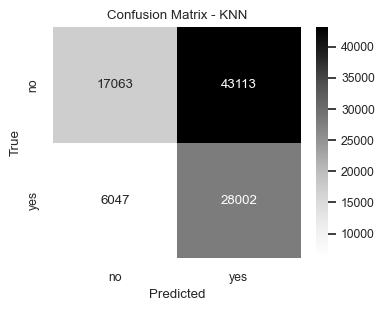

In [25]:
# seu código
# vamos usar o classification report importado no primeiro modelo.
KNeighborsClassifier(metric='manhattan')
print('Relatório de Classificação Detalhado: ')
print()
y_m2_pred = knn.predict(X_test_m2)

report_dict_m2 = classification_report(y_test_m2, y_m2_pred,output_dict=False)
report_df_m2 = pd.read_fwf(StringIO(report_dict_m2), index_col=0)  # Set first column as index

# Fill NaN with empty string to remove 'nan' displays
report_df_m2 = report_df_m2.fillna('')

# Optional: Style it (in Jupyter, this will render with colors/alignment)
styled_df_m2 = report_df_m2.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).set_caption("Classification Report - KNN")

# Display (in Jupyter) or print
display(styled_df_m2)  # Or styled_df.to_html() for HTML output

cm_m2 = confusion_matrix(y_test_m2, y_m2_pred)
# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_m2, annot=True, fmt='d', cmap='Grays', 
            xticklabels=['no', 'yes'], 
            yticklabels=['no', 'yes'])
sns.set(font_scale=0.8)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()

In [20]:
#Visualizando a informação do Modelo 2
print_df(X_test_m2.head())
print(y_test_m2[:5])
print(y_m2_pred[:5])

df_m2_plot = X_test_m2.copy()
df_m2_plot['barrier'] = y_m2_pred
df_m2_plot['barrier_true'] = y_test_m2
print_df(df_m2_plot.head())

df_m2_plot = df_m2_plot.join(df_p4_opc['tradedate'], how='left')
df_m2_plot = df_m2_plot.join(df_p4_opc['next_price_last'], how='left')
df_m2_plot = df_m2_plot.join(df_p4_opc['strike'], how='left')
df_m2_plot['tradedate'] = pd.to_datetime(df_m2_plot['tradedate'], format='%Y-%m-%d')

print_df(df_m2_plot.head())

,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833


29503     0
28214     0
296092    1
269205    0
38687     1
Name: barrier, dtype: int32
[1 1 1 1 1]


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio,barrier,barrier_true
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143,1,0
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155,1,0
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017,1,1
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280,1,0
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833,1,1


,oi,lenders,iq,timo_to_expiry,moneyness,american,covered_ratio,uncovered_ratio,barrier,barrier_true,tradedate,next_price_last,strike
29503,11200,7,0.875000,0.738095,-0.454863,1,0.258929,0.232143,1,0,2023-03-20,23.40,12.50
28214,150700,8,0.421053,0.095238,-0.182717,1,0.033179,0.181155,1,0,2023-03-16,23.51,19.01
296092,763200,46,1.069767,0.091270,0.097906,0,0.075210,0.321017,1,1,2024-11-18,37.80,41.94
269205,19300,1,1.000000,0.325397,-0.429556,1,0.077720,0.922280,1,0,2024-09-19,36.26,20.69
38687,72000,3,1.500000,1.333333,0.837262,1,0.000000,0.995833,1,1,2023-04-14,26.71,48.32


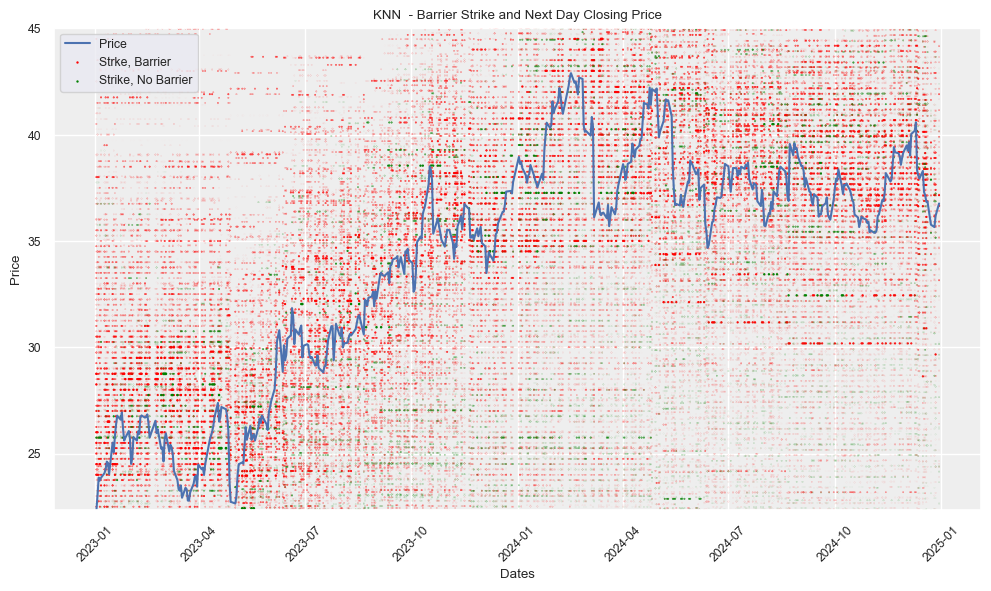

In [21]:
# Criando Gráfico
m2_line = df_m2_plot.drop_duplicates(subset='tradedate', keep='first')
m2_line = m2_line.sort_values(by='tradedate')
m2_line = m2_line[['tradedate', 'next_price_last']].copy()

plt.figure(figsize=(10, 6))



plt.plot(m2_line['tradedate'], m2_line['next_price_last'], label='Price')


df_m2_barrier = df_m2_plot[df_m2_plot['barrier']==1]
max_oi = df_m2_barrier['oi'].max()
plt.scatter(df_m2_barrier['tradedate'], df_m2_barrier['strike'],color='red',s=df_m2_barrier['oi']/max_oi, label='Strke, Barrier')

df_m2_barrier_no = df_m2_plot[df_m2_plot['barrier']==0]
max_oi = df_m2_barrier_no['oi'].max()
plt.scatter(df_m2_barrier_no['tradedate'], df_m2_barrier_no['strike'],color='green',s=df_m2_barrier_no['oi']/max_oi, label='Strike, No Barrier')

plt.ylim(m2_line['next_price_last'].min(), m2_line['next_price_last'].max()*1.05)


# Formatando

plt.gca().set_facecolor('#EEEEEE')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('KNN  - Barrier Strike and Next Day Closing Price')
plt.grid(True)

plt.xticks(rotation=45)


plt.legend()


plt.tight_layout()
plt.show()

# **Conclusão**

*Apresente a conclusão do seu estudo comparando ainda os resultados obtidos com o referencial teórico apresentado.*



Nos utilizamos de 2 modelos distintos:
1. KNN
2. Regressão Logística

o modelo que melhor performou mesmo sem grandes ajustes foi o de **Regressão Logística** por uma grande margem, e o motivo desse modelo ter sido bem melhor é por conta da nossa **Variável Objetivo** que é representada no formato de *range* 0 a 1 (no barrier ou barrier) que se encaixa perfeitamente no modelo de ***Regressão Logística***  que é utilizado nessa situação de rótulos que só tem duas combinações (0 ou 1).

Nosso modelo de KNN utilizamos uma técnica de GridSearch para tentar melhroar os resultados que apesar de uma leve melhora nas métricas não é o suficiente para que o modelo seja razoável para uso real.

Enquanto isso a regressão logística teve excelente resultados que demonstra que o modelo certo é muitas vezes mais importante que a alteração ou melhora dos hiperparâmetros existentes.

**Apresentação:**  



<img src="./qr_yt.png" width=300>


# **Referências**

ZÉ. Distorções no Índice de Qualidade das Opções … O que isso significa ? Clube do Pairico, [s. l.], 2025. Disponível em: https://www.clubedopairico.com.br/distorcoes-no-indice-de-qualidade-das-opcoes-o-que-isso-significa/39249. Acesso em: 7 nov. 2025.  

GÉRON, Aurélien. Hands-on machine learning with Scikit-learn, Keras, and Tensorflow: concepts, tools, and techniques to build intelligent systems. 3. ed. Sebastopol: O'Reilly Media, 2022. 864 p.


---

In [22]:
#@title Avaliação
Completo = 10 #@param {type:"slider", min:0, max:10, step:1}
#@markdown Projeto cumpre todos os itens pedidos.
Relevancia = 9 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As seleções de dados e eventos para análise são relevantes e justificados.
Tecnicas = 6 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As técnicas de empregadas são adequadas e corretamente aplicadas.
Apresentacao = 7 #@param {type:"slider", min:0, max:10, step:1}
#@markdown A apresentação dos resultados é clara e objetiva.
Analise = 8 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As premissas de análise se justificam e a analise é correta.
Conclusao = 7 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As conclusões são justificadas e relevantes
Bonus = 0.5 #@param {type:"slider", min:0, max:1, step:0.5}
#@markdown A critério do professor por inovações na abordagem e no uso de técnicas de Análise de Dados
#







In [23]:
#@markdown ### Nota Final
nota = Completo + Relevancia + Tecnicas + Apresentacao + Analise + Conclusao

nota = nota / 6 + Bonus

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
alunos

Nota final do trabalho 8.3



,tia,nome,nota
0,10423914,HUMBERTO GUTTAU BRAVO,8.3
1,10433651,RICARDO ZULIAN DE SOUZA AMARAL,8.3
